## Chassis Example Notebooks
Welcome to the examples section for [Chassis](https://chassis.ml), which contains notebooks that auto-containerize models built using the most common machine learning (ML) frameworks. 

#### What is Chassis?
Chassis allows you to automatically create a Docker container from your model code and push that container image to a Docker registry. All you need is your model loaded into memory and a few lines of Chassis code! Our example bank is here to provide reference examples for many common ML frameworks.  

Can't find the framework you are looking for or need help? Fork this repository and open a PR, or list the desired framework in a new issue. We're always interested in growing this example bank! 

The primary maintainers of Chassis also actively monitor our [Discord Server](https://discord.gg/cHpzY9yCcM), so feel free to join and ask any questions you might have. We'll be there to respond and help out promptly.

In [64]:
import cv2
import time
import chassisml
import numpy as np
import getpass
import json
import mxnet as mx
import mxnet.image as mxnet_img
from mxnet import gluon, nd
from mxnet.gluon.model_zoo import vision
import matplotlib.pyplot as plt

## Enter credentials
Dockerhub creds and Modzy API Key

In [ ]:
dockerhub_user = getpass.getpass('docker hub username')
dockerhub_pass = getpass.getpass('docker hub password')

## Load and Test Model from MXNET Gluon Model Zoo

In [5]:
# load model
ctx = mx.cpu()
mobileNet = vision.mobilenet0_5(pretrained=True, ctx=ctx)

In [47]:
# load imagenet labels for postprocessing
imagenet_labels = np.array(json.load(open('data/image_net_labels.json', 'r')))
print(imagenet_labels[4])

# load sample image
filename = "data/dog.jpg"

hammerhead, hammerhead shark


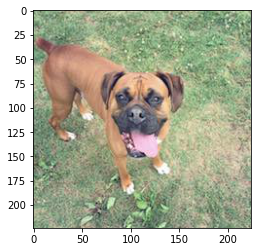

In [67]:
# visualize image to test
image = mx.image.imread(filename)
plt.imshow(image.asnumpy())

In [89]:
# define method for running predictions
def predict(model, image, categories, k=3):
    predictions = model(transform(image)).softmax()
    top_pred = predictions.topk(k=k)[0].asnumpy()
    probs = []
    labels = []
    for index in top_pred:
        probability = predictions[0][int(index)]
        probs.append(probability.asscalar())
        category = categories[int(index)]
        labels.append(category)
    
    return probs, labels

In [90]:
# test model
probs, labels = predict(mobileNet, image, imagenet_labels, 3)
print(probs)
print(labels)

[0.84015656, 0.13626784, 0.006610237]
['boxer', 'bull mastiff', 'Rhodesian ridgeback']


## Write process function

* Must take bytes as input
* Preprocess bytes, run inference, postprocess model output, return results

In [92]:
def process(input_bytes):
    # read image bytes
    img = mxnet_img.imdecode(input_bytes)
    
    # run inference
    probs, labels = predict(mobileNet, img, labels, 3)
    
    # structure results
    inference_result = {
        "classPredictions": [
            {"class": labels[i], "score": probs[i]}
        for i in range(len(probs)) ]
    }

    structured_output = {
        "data": {
            "result": inference_result,
            "explanation": None,
            "drift": None,
        }
    }
    return structured_output

## Initialize Chassis Client
We'll use this to interact with the Chassis service

In [93]:
chassis_client = chassisml.ChassisClient("https://chassis.app.modzy.com")

## Create and test Chassis model
* Requires `process_fn` defined above

In [94]:
# create Chassis model
chassis_model = chassis_client.create_model(process_fn=process)

# test Chassis model locally (can pass filepath, bufferedreader, bytes, or text here):
sample_filepath = './data/dog.jpg'
results = chassis_model.test(sample_filepath)
print(results)

b'{"data":{"result":{"classPredictions":[{"class":"boxer","score":0.8401565551757812},{"class":"bull mastiff","score":0.13626784086227417},{"class":"Rhodesian ridgeback","score":0.0066102370619773865}]},"explanation":null,"drift":null}}'


## Publish model to Docker
Need to provide model name, model version, and Dockerhub credentials

In [96]:
MODEL_NAME = "MXNET MobileNet Image Classifiction"
start_time = time.time()
response = chassis_model.publish(
    model_name=MODEL_NAME,
    model_version="0.0.1",
    registry_user=dockerhub_user,
    registry_pass=dockerhub_pass,
)

Starting build job... Ok!


In [ ]:
job_id = response.get('job_id')
final_status = chassis_client.block_until_complete(job_id)
end_time = time.time()
if final_status['status']['succeeded'] == 1:
    print("Job Completed in {} minutes.\n\nView your new container image here: https://hub.docker.com/repository/docker/{}/{}".format(round((end_time-start_time)/60, 5), dockerhub_user, "-".join(MODEL_NAME.lower().split(" "))))
else:
    print("Job Failed. See logs below:\n\n{}".format(final_status['logs']))